<a href="https://colab.research.google.com/github/roshanbasnet/Image_caption_generator/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIML_2404 AI AND ML LAB

## Project: Image Caption generator
Team Members
* Dishaben
* Harjot
* Naveen
* Roshan
* Vikas



## Step 1:- Import the required libraries

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pickle
import re
import string
import os
import glob
from PIL import Image
from time import time
from imutils import paths

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout,AveragePooling2D
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.metrics import Accuracy
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tqdm import tqdm

## Step 2:- Data loading

We will define all the paths to the files that we require and save the images id and their captions.

We have used the Flickr 8k (containing 8k images) for this purpose, It contains 8,000 images that are each paired with five different captions which provide clear descriptions of the image.

These images are distributed as follows:

* Training Set — 6000 images
* Dev Set — 1000 images
* Test Set — 1000 images


Flickr8k_text : Contains text files describing train_set ,test_set. Flickr8k.token.txt contains 5 captions for each image i.e. total 40460 captions.

In [ ]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip Flickr8k_Dataset.zip -d all_images
# !unzip Flickr8k_text.zip -d all_captions

In [ ]:
# Dataset path
token_path = "/content/all_captions/Flickr8k.token.txt"
train_images_path = '/content/all_captions/Flickr_8k.trainImages.txt'
test_images_path = '/content/all_captions/Flickr_8k.testImages.txt'
validation_image_path = '/content/all_captions/Flickr_8k.devImages.txt'
images_path = '/content/all_images/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/Imagecaption_generator/'

Load Description form the provided path

In [ ]:
# load description from the provided path(path for the token files)
def load_documents(filename):
	# open the file as read only
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
# load descriptions
document = load_documents(token_path)
print(document[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [ ]:
# Function for Loading description, spliting the description into respective its id. As we have 5 descriptions for each of the image. 
# And taking only the description with length higher than 2
def load_descriptions(document):

  descriptions = dict()
  for line in document.split('\n'):
        tokens = line.split()
        # print(tokens)
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          # converting image description to string
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)
  return descriptions

In [ ]:
# We have total of 8092 descriptions 
descriptions = load_descriptions(document)
print('Loaded discription length: %d ' % len(descriptions))

Loaded discription length: 8092 


In [ ]:
list(descriptions.keys())[:3]

['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8']

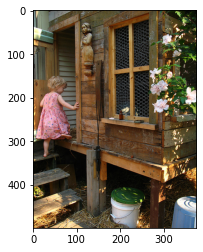

In [ ]:
# Displaying image with key  1000268201_693b08cb0e
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

In [ ]:
# Example of caption/description for one of key 1000268201_693b08cb0e for the image display above.
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Data Cleaning for description
Data cleaning for textual form is performed in this step, where we perform the following operation:
tokenization

* removing space, punctuation
* remove hanging s and a
* remove words having number in them

In [ ]:
#Function to perform the noise removal from the textual dataset
def clean_texts(descriptions):

  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenization
        desc = desc.split()
        # removing  space from each tokens
        desc = [word.strip() for word in desc]
        # converting to lower case
        desc = [word.lower() for word in desc]
        # removing punctuation using string 
        desc = [word.translate(str.maketrans('','',string.punctuation)) for word in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        desc_list[i] =  ' '.join(desc)
    
    # return desc_list  
  # return None

clean_texts(descriptions)


In [ ]:
# Disrption after performing the pre processing
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

As we have total of 8092 total descrtion and each have 5 different description.
For each of the 8092 *5 (i.e. 40460) image captions in the data set, we generate a lexicon comprising all the unique words. In total, there are 8763 distinct terms across the 40460 image descriptions.

In [ ]:
# This is function that will separate all the unique words from all the descriptions and produce the vocabulary.
def convert_tovocabulary(descriptions):
	# build a list of all description strings
	vocabulary = set()
	for key in descriptions.keys():
		for d in descriptions[key]:
			vocabulary.update(d.split())
	return vocabulary

# summarize vocabulary
vocabulary = convert_tovocabulary(descriptions)
print('The Original Vocabulary Size: %d' % len(vocabulary))

The Original Vocabulary Size: 8763


In [ ]:
# function to save descriptions to file, that is saving the image ids and their cleaned captions in the same manner as the orginal token file:-
def save_texts(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_texts(descriptions, '/content/drive/MyDrive/Imagecaption_generator/descriptions.txt')

## Image Data Preprocessing

In [ ]:
# function to load a pre-defined list of iamge id into variable train,test,validatation from the ‘Flickr_8k.trainImages.txt’ file:-

def load_image_dataset(filename):
	doc = load_documents(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		# taking the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training and test  dataset
train = load_image_dataset(train_images_path)
test = load_image_dataset(test_images_path)
validation = load_image_dataset(validation_image_path)
print('Train Dataset: %d' % len(train))
print('Test Dataset: %d' % len(test))
print('Validation Dataset: %d' % len(validation))

Train Dataset: 6000
Test Dataset: 1000
Validation Dataset: 1000


In [ ]:
# Function to create image dataset list and return that list 

def create_image_dataset(images_path,filename):

  # Creating a list of all image names in the directory
  img = glob.glob(images_path + '*.jpg')
  # Read the images names in a set
  images_data = set(open(filename, 'r').read().strip().split('\n'))
  image_data = []
  for i in img: 
    if i[len(images_path):] in images_data:
        image_data.append(i)
  return image_data

In [ ]:
# Creating train, test and validation image dataset,
# images_path = Path of all the images
# train_images_path = Path of txt file containing the id of train image
# images_path = Path of txt file containing the id of test image


train_image = create_image_dataset(images_path,train_images_path)
test_image = create_image_dataset(images_path,test_images_path)
validation_image = create_image_dataset(images_path,validation_image_path)

print('Train Dataset: %d' % len(train_image))
print('Test Dataset: %d' % len(test_image))
print('Validation Dataset: %d' % len(validation_image))

Train Dataset: 6000
Test Dataset: 1000
Validation Dataset: 1000


Now we laod the descriptions of these images into the Python dictionary "train descriptions" from "descriptions.txt"(which we have saved previously).
When we load them, we'll add two tokens to each caption, as follows :

* **'startseq'** -> A start sequence token will be appended to the beginning of each caption.
* **'endseq'** -> An end sequence token that will be appended to the end of each caption.

In [ ]:
# function to load the clean desctiptoion that we have save previously. Also including the tokens'startseq' and 'endseq' in each caption

def load_clean_texts(filename, dataset):
	# load document
	doc = load_documents(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# Loading all the cleaned descriptions
train_descriptions = load_clean_texts('/content/drive/MyDrive/Imagecaption_generator/descriptions.txt', train)
test_descriptions = load_clean_texts('/content/drive/MyDrive/Imagecaption_generator/descriptions.txt', test)
validation_descriptions = load_clean_texts('/content/drive/MyDrive/Imagecaption_generator/descriptions.txt', validation)
print('Descriptions: train=%d' % len(train_descriptions))
print('Descriptions: Test=%d' % len(test_descriptions))
print('Descriptions: Validation=%d' % len(validation_descriptions))

Descriptions: train=6000
Descriptions: Test=1000
Descriptions: Validation=1000


In [ ]:

# Creating a list of all the training captions
all_train_captions = []
for key, value in train_descriptions.items():
    for caption in value:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [ ]:
# Creating a list of all the test captions
all_test_captions = []
for key, value in test_descriptions.items():
    for caption in value:
        all_test_captions.append(caption)
len(all_test_captions)

5000

### To make our model more robust we decided to take takes only the words that appear more than 10 times in the entire documents 

Many of these terms will only appear a few of times, perhaps once, twice, or three times. We don't want all of the terms in our vocabulary because we're building a predictive model; we only want the words that are more likely to appear or are common. This makes the model more resistant to outliers and less prone to errors.
As a result, we only evaluate terms that appear at least 10 times throughout the corpus. The following is the code for this:

In [ ]:
# function to take words that are appearing more than 10 times in entire documents
def take_word_appearing_ten_more(captions):
  word_count_threshold = 10
  word_counts = {}
  nsents = 0
  for sent in captions:
      nsents += 1
      for w in sent.split(' '):
          word_counts[w] = word_counts.get(w, 0) + 1

  vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

  return vocab


In [ ]:
# So the vocabulary list is decreases to 1651 after considering words that are appearing more than 10 same for the test dataset
train_vocab = take_word_appearing_ten_more(all_train_captions)
test_vocab = take_word_appearing_ten_more(all_test_captions)
print('preprocessed Train words %d' %  len(train_vocab))
print('preprocessed Test words %d' %  len(test_vocab))

preprocessed Train words 1651
preprocessed Test words 526


In [ ]:
# Saving the train vocabulary into drive for future use
with open("/content/drive/MyDrive/Imagecaption_generator/train_vocab.pkl", "wb") as encoded_pickle:
    pickle.dump(train_vocab, encoded_pickle)

#Saving the test model vocab into phyisical memory
with open("/content/drive/MyDrive/Imagecaption_generator/train_vocab.pkl", "wb") as encoded_pickle:
    pickle.dump(train_vocab, encoded_pickle)

* wordto_index[‘abc’] -> returns index of the word ‘abc’
* indexto_word[k] -> returns the word whose index is ‘k’

In [ ]:
# Function to create word to index and index to word
def creat_index_to_word_viceversa(vocab):
  indexto_word = {}
  wordto_index = {}
  index = 1
  for word in vocab:
      wordto_index[word] = index
      indexto_word[index] = word
      index += 1
  return wordto_index,indexto_word

In [ ]:
train_wordto_index,train_indexto_word = creat_index_to_word_viceversa(train_vocab)
test_wordto_index,test_indexto_word = creat_index_to_word_viceversa(test_vocab)
print("train Voacb Size:",len(train_wordto_index)+1)
print("Test Voacb Size:",len(test_wordto_index)+1)

train_vocab_size = len(train_wordto_index)+1
test_vocab_size = len(test_wordto_index)+1

train Voacb Size: 1652
Test Voacb Size: 527


In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
  all_desc = list()
  for key in descriptions.keys():
   [all_desc.append(d) for d in descriptions[key]]
  return max(len(d.split()) for d in all_desc)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
def image_preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception v3 module
    x = preprocess_input(x)
    return x

#####Loading inception v3 model for image encoding 

In [ ]:
# Load the inception v3 model
base_model = InceptionV3(weights='imagenet')
# base_model=InceptionV3(weights='imagenet',include_top=False)

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(base_model.input, base_model.layers[-2].output)
# model_new = Model(base_model.input, base_model.output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode_image(image):
    image = image_preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

This section is code for generation the image vector for train dataset which takes time so run only once and save the generated vector for later use

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in tqdm(train_image):
    encoding_train[img[len(images_path):]] = encode_image(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 6000/6000 [11:01<00:00,  9.07it/s]

Time taken in seconds = 661.2503643035889


In [ ]:
# Save the bottleneck train features to disk
with open("/content/drive/MyDrive/Imagecaption_generator/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

Section for generating image vector for test dataset

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in tqdm(test_image):
    encoding_test[img[len(images_path):]] = encode_image(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 1000/1000 [01:48<00:00,  9.23it/s]

Time taken in seconds = 108.35629558563232


In [ ]:
# Save the bottleneck test features 
with open("/content/drive/MyDrive/Imagecaption_generator/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

### Load Train Features

In [ ]:
# Loading the save train image features
train_features = pickle.load(open("/content/drive/MyDrive/Imagecaption_generator/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Loading the save test image features
test_features = pickle.load(open("/content/drive/MyDrive/Imagecaption_generator/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


## Step 3:- Glove Embeddings

Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.


In [ ]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
  # contain word and its coeffiecient
    values = line.split()
    # print(values)
    # taking words 
    word = values[0]
    #taking the coeffiecnet of the words
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

128442it [00:07, 17117.36it/s]

Found 128442 word vectors.


In [ ]:
# embeddings_index
embedding_dim=200
def create_embedding_dim(wordto_index,vocab_size):
  embedding_dim = 200
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in wordto_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [ ]:
train_embedding_matrix = create_embedding_dim(train_wordto_index,train_vocab_size)
# test_embedding_matrix = create_embedding_dim(test_wordto_index,test_vocab_size)

In [ ]:
train_embedding_matrix.shape

(1652, 200)

In [ ]:
def data_generator(descriptions, photos, wordto_index, max_length, num_photos_per_batch,vocab_size):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordto_index[word] for word in desc.split(' ') if word in wordto_index]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

## Step 4:- Model Building and Training

In [ ]:
#input layer1 for image CNN layer
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(train_vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(train_vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 200)      330400      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([train_embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
train_generator = data_generator(train_descriptions, train_features, train_wordto_index, max_length, number_pics_per_bath,train_vocab_size)
model.fit(train_generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
model.save('/content/drive/MyDrive/Imagecaption_generator/my_model_new.h5')

Epoch 1/20
1000/1000 [==============================] - 158s 152ms/step - loss: 5.1511
Epoch 2/20
1000/1000 [==============================] - 152s 152ms/step - loss: 4.4133
Epoch 3/20
1000/1000 [==============================] - 152s 152ms/step - loss: 4.0676
Epoch 4/20
1000/1000 [==============================] - 152s 152ms/step - loss: 3.8747
Epoch 5/20
1000/1000 [==============================] - 153s 153ms/step - loss: 3.7439
Epoch 6/20
1000/1000 [==============================] - 151s 151ms/step - loss: 3.6423
Epoch 7/20
1000/1000 [==============================] - 150s 150ms/step - loss: 3.5601
Epoch 8/20
1000/1000 [==============================] - 148s 148ms/step - loss: 3.4906
Epoch 9/20
1000/1000 [==============================] - 149s 149ms/step - loss: 3.4326
Epoch 10/20
1000/1000 [==============================] - 151s 151ms/step - loss: 3.3798
Epoch 11/20
1000/1000 [==============================] - 150s 150ms/step - loss: 3.3361
Epoch 12/20
1000/1000 [==================

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save('/content/drive/MyDrive/Imagecaption_generator/my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Load saved trained models

In [ ]:
# Model Load
from tensorflow.keras.models import load_model

In [ ]:
# Model Load
# model.load_weights('/content/drive/MyDrive/Imagecaption_generator/my_model_new.h5')
model = load_model('/content/drive/MyDrive/Imagecaption_generator/my_model_new.h5')

## 5 Model EValutation using BELU

* The BLEU metric is a way to compare a generated sentence to a reference sentence. The score was created to assess the accuracy of automatic machine translation systems' predictions. A perfect match receives a 1.0 score, whereas a perfect mismatch receives a 0.0 value. The corpus BLEU score, which describes how near the generated text is to the expected text, is used to evaluate the actual and predicted descriptions.

* NLTK has a method called **corpus_bleu()** that is used to calculate the BLEU score for a group of sentences, such as a paragraph or a document.

* Each document must be defined as a list of references, and each alternative reference must be specified as a list of tokens.

* The cumulative and individual 1-gram BLEU weights are the same, e.g. (1, 0, 0, 0). The 2-gram weights assign 50% to each of 1-gram and 2-gram, and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores.

* The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. For example:


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

def evaluate_model(descriptions,test_features):
  actual,predicted = list(),list()

  for key, desc_list in tqdm(descriptions.items()):
    # print(key,desc_list)
    photo = test_features[key+'.jpg'].reshape((1,2048)) 
    yhat = greedySearch(photo)
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# Loading the save test image features
test_features = pickle.load(open("/content/drive/MyDrive/Imagecaption_generator/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
test_descriptions = load_clean_texts('/content/drive/MyDrive/Imagecaption_generator/descriptions.txt', test)
print('Description: test=%d' % len(test_descriptions))

evaluate_model(test_descriptions,test_features)

Photos: test=1000
Description: test=1000


100%|██████████| 1000/1000 [08:50<00:00,  1.88it/s]


BLEU-1: 0.476259
BLEU-2: 0.291360
BLEU-3: 0.205774
BLEU-4: 0.100989


## Step 6: Generate Description Using Greedy Search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [train_wordto_index[w] for w in in_text.split() if w in train_wordto_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = train_indexto_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
# Loading the save test image features
test_features = pickle.load(open("/content/drive/MyDrive/Imagecaption_generator/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


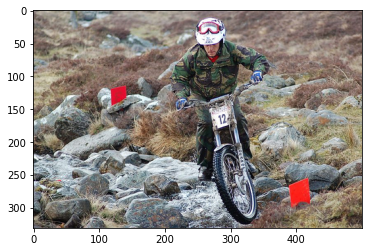

Actual Description: ['man dressed in camouflage riding motorbike', 'man is going between two red flag markers on dirt bike', 'man is riding dirt bike over some rocks', 'man wearing camouflage steers motorcycle across some stones', 'the man waeribng helmet is riding dirt bike over rocks']

Predicted Result By Greedy: man in red shirt is riding bike


In [ ]:
z=0
z += 1
pic = list(test_features.keys())[z]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Actual Description:",descriptions[pic.split(".",1)[0]])
print("\nPredicted Result By Greedy:",greedySearch(image))

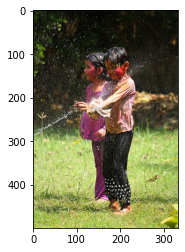

Actual Description: ['children with painted red faces being sprayed with water on grass', 'the two children are being sprayed by water', 'two children playing in spray of water', 'two children standing in the grass being sprayed by hose', 'two indian children are being squirted by jet of water']

Predicted Result By Greedy: little boy in red shirt is playing in the grass


In [ ]:
# z=0
z += 2
pic = list(test_features.keys())[z]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Actual Description:",descriptions[pic.split(".",1)[0]])
print("\nPredicted Result By Greedy:",greedySearch(image))

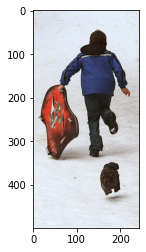

Actual Description: ['boy drags his sled through the snow', 'boy in blue jacket carrying red sled running away followed by small dog', 'child running with snowboard on snow covered surface', 'child wearing blue coat runs along the snow while small dog follows', 'young boy plays with his dog in the snow']

Predicted Result By Greedy: boy in red shirt is walking down the snow


In [ ]:
# z=0
z += 4
pic = list(test_features.keys())[z]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Actual Description:",descriptions[pic.split(".",1)[0]])
print("\nPredicted Result By Greedy:",greedySearch(image))

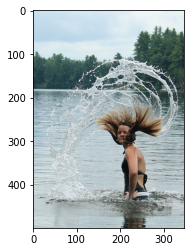

Actual Description: ['girl is shaking the water out of her hair', 'girl swings her long wet hair in lake', 'girl whipping water from her hair in lake', 'woman in river is shaking her hair causing water to spray everywhere', 'woman splashes in the water']

Predicted Result By Greedy: girl in swimsuit is splashing in the water


In [ ]:
## z=0
z += 5
pic = list(test_features.keys())[z]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Actual Description:",descriptions[pic.split(".",1)[0]])
print("\nPredicted Result By Greedy:",greedySearch(image))